# Tracking Errors

This will display the tracking errors for both the RA and Dec axis. Tracking errors are determined through the center of the image and do not take into account rotation.

In [1]:
from glob import glob
import os

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import modeling
from astropy.stats import sigma_clip
from scipy.optimize import leastsq

from matplotlib import pyplot as plt
import pandas
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

plt.style.use('bmh')

rcParams['axes.formatter.useoffset'] = False

from pocs.utils import images as img_utils
from pocs.utils.jupyter import widgets
from piaa import utils

%matplotlib inline

## Gather Images

In [2]:
base_dir = '/var/panoptes/images/fields/'
image_dir = 'HatP3/14d3bd/20170417T060110/'

seq_files = glob('{}/{}/2*.fits'.format(base_dir, image_dir), recursive=True)
seq_files.sort()
print("Number of files: {}".format(len(seq_files)))

Number of files: 26


## Collect WCS info

In [3]:
wcsinfo_list = {}

for f in seq_files:
    head, tail = os.path.split(f)
    if head in wcsinfo_list:
        wcsinfo_list[head].append(img_utils.get_wcsinfo(f))
    else:
        wcsinfo_list[head] = [img_utils.get_wcsinfo(f)]

In [4]:
ra = {}
d_ra = {}
ha = {}
d_dec = {}
t = {}
dt = {}
rate ={}
dec = {}

for item, wcsinfo in wcsinfo_list.items():
    print(item)
    try:
        ra[item] = np.array([(info['ra_center'].to(u.arcsec)).value for info in wcsinfo])
        d_ra[item] = np.array([((info['ra_center'] - wcsinfo[0]['ra_center']).to(u.arcsec)).value for info in wcsinfo])
        d_dec[item] = np.array([((info['dec_center'] - wcsinfo[0]['dec_center']).to(u.arcsec)).value for info in wcsinfo])
        dec[item] = np.array([(info['dec_center'].to(u.arcsec)).value for info in wcsinfo])
    except KeyError:
        next
    
    try:
        rate[item] = np.array([fits.getval(info['wcs_file'], 'RA-RATE') for info in wcsinfo])
    except KeyError:
        pass
    ha[item] = np.array([fits.getval(info['wcs_file'], 'HA-MNT') for info in wcsinfo])
    t[item] = pandas.to_datetime([fits.getheader(info['wcs_file'])['DATE-OBS'] for info in wcsinfo])
    dt[item] = np.array([((t1-t[item][0]).seconds) / 60 for t1 in t[item]])

/var/panoptes/images/fields//HatP3/14d3bd/20170417T060110


## Plotting Options

In [5]:
color = {
    1.0: 'r',
    0.99: 'b',
    1.01: 'g',
}

marker = {
    'Wasp35': 'x',
    'Wasp36': 's',
    'Wasp104': 'D',
    'HatP20': '8',
    'HatP12': '8',    
    'Epic211089792': 'o',
    'Kepler1100': 'x',
    'Kic8462852': 'x',    
    'Tres3': 'x'
}

pixscale = 10.309 * (u.arcsec / u.pixel)

## Set up fitting functions

In [6]:
linear = modeling.functional_models.Linear1D(slope=-1)
poly = modeling.polynomial.Polynomial1D(degree=2)
fit = modeling.fitting.LinearLSQFitter() #LevMarLSQFitter()

In [7]:
ra_models = dict()
dec_models = dict()

## Plot the tracking

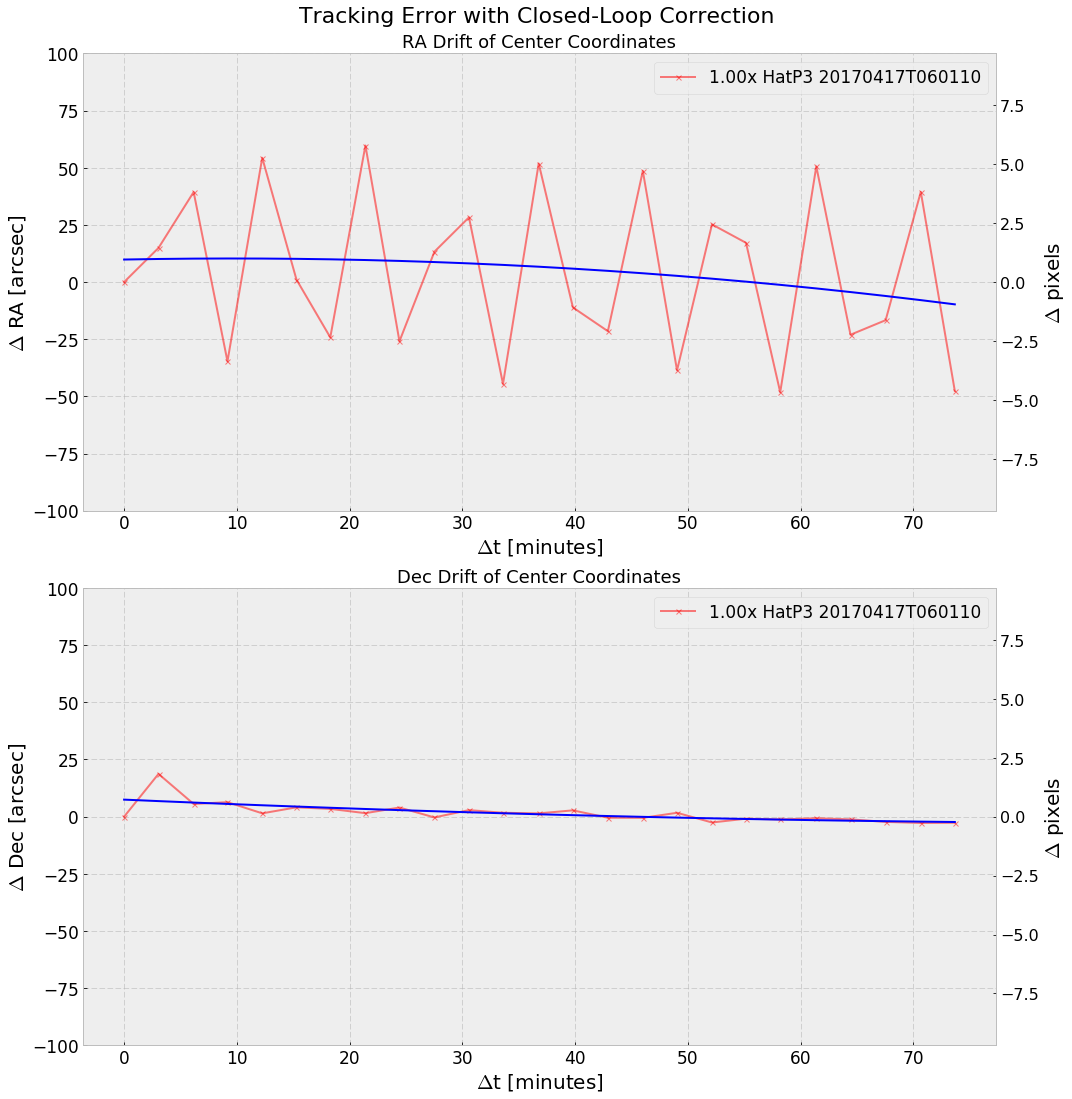

In [16]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

min_ha = 100
max_ha = -100

fitted_model = None
fitted_model2 = None

for item in sorted(list(d_ra.keys())):
           
    label = item.replace('/14d3bd/', ' ').replace(base_dir + '/', '')
        
    r = round(rate[item][0], 2)
    
    x0 = ha[item][0:-1]
    x1 = dt[item][0:-1]
    x0 = x1
    
    y0 = d_ra[item][0:-1]
    mark = marker.get(item.split('/')[0], 'x')
    ax1.plot(x0, y0, 
             label='{:.02f}x {}'.format(r, label), 
             alpha=0.5, marker=mark, ms=5, color=color[r])
        
    # Fit
    fitted_model = fit(poly, x0, y0)
    ra_models[item] = fitted_model
    ax1.plot(x0, fitted_model(x0), 'b')
#     ax1.plot(x0, d_ra[item][0:-1] - fitted_model(x0), 'g')

    # Dec
    y1 = d_dec[item][0:-1]
    ax2.plot(x0, y1, 
             label='{:.02f}x {}'.format(r, label), 
             alpha=0.5, marker=mark, ms=5, color=color[r])    
    
    # Fit
#     if fitted_model2 is None:
    fitted_model2 = fit(poly, x0, y1)
    dec_models[item] = fitted_model2

    ax2.plot(x0, fitted_model2(x0), 'b')    
#     ax2.plot(x0, y1 - fitted_model2(x0), 'g')
    

ax1.set_xlabel("$\Delta$t [minutes]", fontsize=20)
ax1.set_ylabel('$\Delta$ RA [arcsec]', fontsize=20)
ax1.tick_params(labelsize=17)
ax1.set_ylim(-100,100)
ax1.set_title("RA Drift of Center Coordinates", fontsize=18)

ax2.set_xlabel("$\Delta$t [minutes]", fontsize=20)
ax2.set_ylabel('$\Delta$ Dec [arcsec]', fontsize=20)
ax2.tick_params(labelsize=17)
ax2.set_ylim(-100,100)
ax2.set_title("Dec Drift of Center Coordinates", fontsize=18)

# Pixel labels
ax3 = ax1.twinx()
ax3.set_ylabel('$\Delta$ pixels', fontsize=20)
ax3.tick_params(labelsize=16)
arcs = ax1.get_yticks()
ax3.set_ylim(arcs[0] / 10.31, arcs[-1] / 10.31)
ax3.grid(False)

# Pixel labels
ax3 = ax2.twinx()
ax3.set_ylabel('$\Delta$ pixels', fontsize=20)
ax3.tick_params(labelsize=16)
arcs = ax2.get_yticks()
ax3.set_ylim(arcs[0] / 10.31, arcs[-1] / 10.31)
ax3.grid(False)

ax1.legend(fontsize=17)
ax2.legend(fontsize=17)

plt.suptitle('Tracking Error with Closed-Loop Correction', y=1.015, fontsize=22)
plt.tight_layout()
plt.savefig('/var/panoptes/plots/tracking_rate.png', dpi=300)